<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Seyed Mohammad Ojagh Kazzazi

**Student ID**: 400100554

# ****Support Vector Machines****

In this notebook, you will implement SVM for three datasets. You will become more familiar with the Soft-Margin SVM and the Kernel trick, which makes SVM extremely powerful.

Before we start our implementation, you must be comfortable with the theoretical details of the Soft-Margin SVM as an optimization problem and be able to derive the dual formulation for this problem. In the next sections, you will solve the dual optimization problem for all datasets using the CVXPY library, which has been developed for solving convex optimization problems. To get more familiar with CVXPY programming, you can use this [link](https://www.cvxpy.org).

This is the primal formulation for the Soft-Margin SVM for linearly separable data with slack variables $\xi_i \ge 0$:

\begin{equation*}
\begin{aligned}
& {\text{min.}}
& & \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{N} \xi_i \\
& \text{s.t.}
& & y_i(w^T x_i + b) \geq 1 - \xi_i, \; i = 1, \ldots, N \\
& & & \xi_i \geq 0, \; i = 1, \ldots, N
\end{aligned}
\end{equation*}

Where $w$ represents the weight vector, $b$ is the bias term, and $C$ is the regularization parameter controlling the trade-off between a wide margin and misclassification.

**Theoretical Questions:**

1) Derive the dual optimization problem for the Soft-Margin SVM.

2) How do we calculate the weights and bias ($w$ and $b$) using the dual problem optimum points?

3) How do we classify new data points using the optimal weights and bias?

<font color='green'>Write down your answers as markdown here.</font>

Sometimes, the data is not linearly separable. Therefore, the previous formulation of the Soft-Margin SVM does not give a good accuracy for the classification problem. The Kernel trick is a technique used in such situations. Consider $x$ as your input features with dimension $p$. One can use function $\phi: R^p → R^d$ to map the input features to another space with dimension $d$. Finding good $\phi$ such that data points become near linearly separable makes the previous formulation of the problem and its dual useful by replacing $\phi(x_i)$ for $x_i$ in the problem definition. The function $\phi(x)$ can even be a mapping to an infinite-dimensional space.

If you have found the correct dual form of the Soft-Margin SVM in the previous formulation, you can see that the terms $x_i^T x_j$ will appear in the problem formulation and the prediction rule. These terms will be replaced with $\phi(x_i)^T \phi(x_j)$ when we use $\phi$ as our feature mapping function. Given a feature mapping $\phi$ we define its corresponding **Kernel** to be:

\begin{equation*}
\begin{aligned}
& K(x, z) = \phi(x)^T \phi(z)
\end{aligned}
\end{equation*}

Hence, in the dual optimization problem and the prediction rule of the Soft-Margin SVM, we can replace all terms in the form $x^T z$ with $K(x, z)$. This technique is called the Kernel trick.

Now, given $\phi$, we could easily compute $K(x,z)$ by finding $\phi(x)$ and $\phi(z)$ and taking their inner product. But what’s more interesting is that often, $K(x,z)$ may be very inexpensive to calculate, even though $\phi(x)$ itself may be very expensive to calculate (perhaps because it is an extremely high-dimensional vector). Check Stanford's CS229 [notes](https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf) on SVM and the Kernel trick for more details and examples.

## Libraries

Here are some useful libraries for the implementation. You can add or remove any libraries as you wish. Note that you cannot use sklearn or similar libraries for implementation.

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score
import cvxpy as cp

## **Dataset Exploration**

In this notebook, you'll be working with three datasets, specifically named "DF1.csv", "DF2.csv", and "DF3.csv". Each dataset entry is composed of a 2-dimensional feature vector and a label, which is either "1" or "-1". The primary objective of this notebook is to leverage SVM to develop a robust classifier for each dataset.

You are given three kernels as follows:



1.   Linear Kernel: $K(x, z) = x^T z$
2.   Polynomial Kernel of degree 2: $K(x, z) = (1 + ∑_{i = 1}^{p} x_i z_i)^2$, where $p$ is the dimension of the feature space.
3.   RBF Kernel: $K(x, z) = e^{-\frac{||x-z||_2^2}{2σ^2}}$

Before implementing, you must choose the correct kernel for each dataset. Note that each kernel must be used exactly for one dataset. Therefore, you cannot use one of the kernels twice. As a part of our grading scheme, what matters with respect to accuracy is the sum of the accuracies you reach for all three datasets, and the accuracy of each model does not have any separate score. Thus, it would help if you chose the most appropriate kernel for each dataset so that all datasets reach a reasonably good accuracy.





Load all datasets and show the first 5 rows of each.

In [178]:
# Dataset filenames
filenames = ['DF1.csv', 'DF2.csv', 'DF3.csv']

DFs = []
# Load and display the first 5 rows of each dataset
for filename in filenames:
    df = pd.read_csv(filename)
    DFs.append(df)
    print(f"First 5 rows of {filename}:")
    print(df.head(), "\n")

First 5 rows of DF1.csv:
         x1        x2  y
0  6.462652  5.121478 -1
1 -6.586541 -7.721287  1
2  9.239683 -8.595738 -1
3  4.250052  2.143755  1
4  8.219779 -3.609733 -1 

First 5 rows of DF2.csv:
         x1         x2  y
0  2.937145  77.102291  1
1 -0.029344  44.802353  1
2  5.868818  44.595757 -1
3  8.609281  49.223945 -1
4  7.763276 -14.340750 -1 

First 5 rows of DF3.csv:
         x1        x2  y
0 -0.517768 -0.466158 -1
1  0.940985  0.235175  1
2 -0.470720  0.917120  1
3  0.712716 -0.097401 -1
4 -0.608773 -0.107034 -1 



Use the following function to visualize the datapoints for all datasets.

Visualizing DF1.csv:


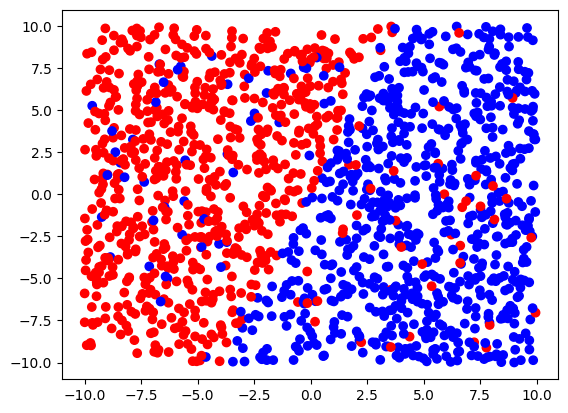

Visualizing DF2.csv:


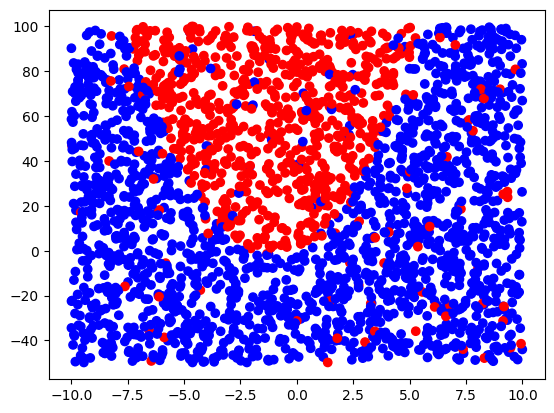

Visualizing DF3.csv:


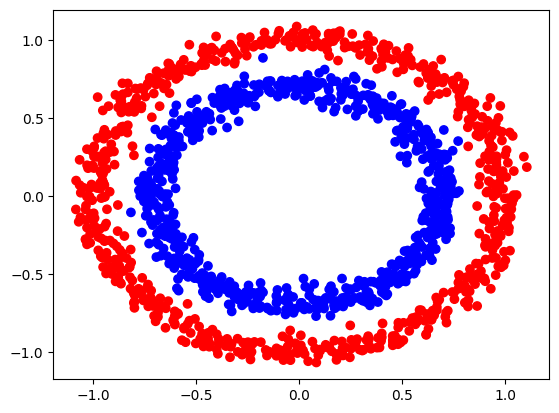

In [179]:
def visualize_data(X, y):
  col = []
  for i in range(len(y)):
    if y[i] == 1:
      col.append('red')
    else:
      col.append('blue')
  plt.scatter(X[ : , 0], X[ : , 1], color = col)
  plt.show()


for i in range(len(DFs)) :  
  
    df = DFs[i]
    # Extract features and labels
    X = df.drop('y', axis=1).values
    y = df['y'].values
    
    # Visualize dataset
    print(f"Visualizing DF{i+1}.csv:")
    visualize_data(X, y)

**Theoretical Question:**

Which kernel will you use for each dataset? Justify your answer.

Note: your implementation must follow your choice here. Otherwise, you do not recieve any points for your implemetation.

<font color='green'>Write down your answers as markdown here.</font>

Based on the observations of the datasets:

### DF1 is linearly separable:

Kernel Choice: Linear Kernel

reason: For datasets that are linearly separable, the linear kernel is the simplest and most efficient choice. It effectively separates the data with a straight line (or hyperplane in higher dimensions), ensuring low computational cost and avoiding overfitting.


### DF2 is likely Gaussian:

Kernel Choice: RBF (Radial Basis Function) Kernel

reason: The RBF kernel is well-suited for datasets with Gaussian distributions or when the data points are not linearly separable. It maps the input space into a higher-dimensional space where a linear separation is possible, handling complex and non-linear relationships effectively.


### DF3 is circular:

Kernel Choice: Polynomial Kernel of degree 2

reason: For datasets with circular patterns, a polynomial kernel can create decision boundaries that fit the circular nature of the data. A polynomial kernel of degree 2 is effective for such patterns, as it can model the circular relationships without overfitting.


Summary:
 - DF1.csv: Linear Kernel

 - DF2.csv: RBF Kernel

 - DF3.csv: Polynomial Kernel of degree 2

## Dataset one (DF1.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [180]:
df1 = DFs[0]

# Define features and target
X = df1[['x1', 'x2']]
y = df1['y']

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_np = np.array(X_train_scaled)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test_scaled)
y_test_np = np.array(y_test)


# Display the shapes of the resulting sets
print(X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)

(1180, 2) (296, 2) (1180,) (296,)


Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [181]:
def compute_bias(alpha, y_train, K, support_vector_indices):
    return np.mean(y_train[support_vector_indices] - np.dot(K[support_vector_indices], alpha * y_train))

def svm_solver(X_train, y_train):
    n_samples = X_train.shape[0]
    K = X_train @ X_train.T + np.eye(n_samples) * 1e-6  # Kernel matrix with adjustment

    alpha = cp.Variable(n_samples)
    P = np.multiply(np.outer(y_train, y_train), K)  # Element-wise multiplication for P matrix

    objective = cp.Maximize(1/2 * cp.quad_form(alpha, -P) + cp.sum(alpha))
    constraints = [alpha >= 0, alpha <= 1, cp.sum(alpha * y_train) == 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    alpha_value = alpha.value
    sv_indices = alpha_value > 1e-5
    sv = X_train[sv_indices]
    sv_labels = y_train[sv_indices]
    bias = compute_bias(alpha_value, y_train, K, sv_indices)

    return alpha_value, sv_indices, sv, sv_labels, bias

# Assuming X_train_scaled and y_train are defined
alpha_value, sv_indices, support_vectors, support_vector_labels, bias = svm_solver(X_train_np, y_train_np)

print("Optimal alpha values:", alpha_value)
print("Support vectors:", support_vectors)
print("Bias term:", bias)

/opt/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 28 times so far.

  warnings.warn(msg, UserWarning)


Optimal alpha values: [ 1.00000000e+00 -3.03123491e-21 -7.48412404e-21 ...  1.00000000e+00
 -3.55894917e-20  4.16999911e-21]
Support vectors: [[-0.15265259 -0.72296314]
 [-0.55828377 -1.31759686]
 [ 0.22857657 -0.47574752]
 [ 0.46924419  0.52756192]
 [ 0.20318049  1.06492334]
 [ 0.00611474  1.45405703]
 [ 1.21039032  0.20278487]
 [ 0.60417587  1.01946141]
 [-0.07491312  0.93231023]
 [-0.78702027  1.4702921 ]
 [ 0.80379007 -0.73365584]
 [ 0.24778107  0.72915775]
 [-0.16902482 -1.74993068]
 [-1.55412291 -0.65902585]
 [-0.23842279 -1.29232274]
 [-0.24150154  1.12881813]
 [-0.62419984 -0.62749083]
 [-0.4008758  -0.0095192 ]
 [-0.56517366 -1.04014909]
 [ 1.08992562 -0.72134088]
 [-0.07282271 -0.41171826]
 [ 0.70796021 -1.50214695]
 [-0.36980566 -1.63121858]
 [ 0.09298536  1.13596609]
 [-0.71796055 -0.76567257]
 [-0.12912142  1.00853188]
 [ 1.10554453 -0.13143378]
 [-0.40834387 -0.38101244]
 [ 0.05927211  1.26114496]
 [-0.60888759 -0.56346065]
 [-0.17073113 -0.52088888]
 [ 0.6976617   1.3013

Predict the class of each entry in the test set using your learned model.

In [182]:
def predict(X, support_vectors, support_vector_indices, alpha, y_train, bias):
    """
    Predict the class labels for the input samples X using the learned SVM model.
    
    Args:
    - X (numpy array): Test samples to predict.
    - support_vectors (numpy array): Support vectors from the training set.
    - support_vector_indices (numpy array): Indices of the support vectors.
    - alpha (numpy array): Optimal alpha values from the SVM solver.
    - y_train (numpy array): Training labels.
    - bias (float): Bias term from the SVM solver.

    Returns:
    - y_pred (numpy array): Predicted class labels for the input samples X.
    """
    # Only use the support vectors' alphas and labels
    support_alphas = alpha[support_vector_indices]
    support_y_train = y_train[support_vector_indices]

    # Compute the kernel between the test samples and support vectors
    K_test = X @ support_vectors.T
    
    # Compute the decision function
    decision_function = np.dot(K_test, support_alphas * support_y_train) + bias
    
    # Predict the class labels based on the sign of the decision function
    y_pred = np.sign(decision_function)
    
    return y_pred

# Assuming X_test_scaled is defined
y_pred = predict(X_test_scaled, support_vectors, sv_indices, alpha_value, y_train_np, bias)

print("Predicted class labels:", y_pred)


Predicted class labels: [-1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1.  1.
  1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1.
  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1.
  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.
  1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.
  1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.
  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.
  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.
 -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1.
 -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1.
  1.  1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1. -1

Use classification_report function (from sklearn) to get the accuracy of your model.

              precision    recall  f1-score   support

          -1       0.92      0.93      0.92       148
           1       0.93      0.92      0.92       148

    accuracy                           0.92       296
   macro avg       0.92      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296

Accuracy: 0.9222972972972973


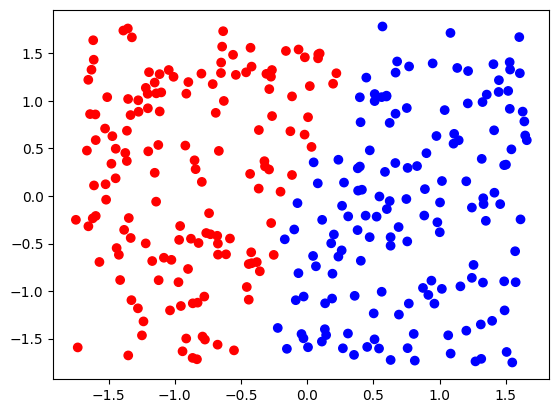

In [183]:
report = classification_report(y_test, y_pred)
print(report)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
visualize_data(X_test_np, y_pred)


## Dataset two (DF2.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [184]:
df2 = DFs[1]

# Define features and target
X = df2[['x1', 'x2']]
y = df2['y']

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_np = np.array(X_train_scaled)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test_scaled)
y_test_np = np.array(y_test)


# Display the shapes of the resulting sets
print(X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)

(1980, 2) (496, 2) (1980,) (496,)


Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [185]:
def rbf_kernel(X, Y, gamma=0.1):
    sq_dists = -2 * np.dot(X, Y.T) + np.sum(X**2, axis=1)[:, np.newaxis] + np.sum(Y**2, axis=1)
    K = np.exp(-gamma * sq_dists)
    return K

def svm_solver(X_train, y_train, gamma=0.2):
    n_samples = X_train.shape[0]
    K = rbf_kernel(X_train, X_train, gamma) + np.eye(n_samples) * 1e-6  # Kernel matrix with adjustment

    alpha = cp.Variable(n_samples)
    P = np.multiply(np.outer(y_train, y_train), K)  # Element-wise multiplication for P matrix

    # Ensure matrix P is treated as PSD without certification step
    P = cp.psd_wrap(P)

    objective = cp.Maximize(1/2 * cp.quad_form(alpha, -P) + cp.sum(alpha))
    constraints = [alpha >= 0, alpha <= 1, cp.sum(alpha * y_train) == 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    alpha_value = alpha.value
    sv_indices = alpha_value > 1e-5
    sv = X_train[sv_indices]
    sv_labels = y_train[sv_indices]
    bias = compute_bias(alpha_value, y_train, K, sv_indices)

    return alpha_value, sv_indices, sv, sv_labels, bias

def compute_bias(alpha, y_train, K, support_vector_indices):
    return np.mean(y_train[support_vector_indices] - np.dot(K[support_vector_indices], alpha * y_train))

# Assuming X_train_np, y_train_np, X_test_scaled are defined
alpha_value, sv_indices, support_vectors, support_vector_labels, bias = svm_solver(X_train_np, y_train_np)

print("Optimal alpha values:", alpha_value)
print("Support vectors:", support_vectors)
print("Bias term:", bias)


/opt/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 29 times so far.

  warnings.warn(msg, UserWarning)


Optimal alpha values: [ 1.09970307e-20  1.00000000e+00  5.39546174e-20 ... -3.22529763e-20
 -2.60616737e-20 -1.49086200e-20]
Support vectors: [[-0.6732123   0.48487136]
 [ 0.4074034  -0.51340748]
 [-0.96551875  0.73986201]
 ...
 [-0.34444902  0.27274969]
 [ 1.55755952  1.06870802]
 [-1.01125241  0.68348163]]
Bias term: -1.7508493093538087


Predict the class of each entry in the test set using your learned model.

In [186]:
def predict(X, support_vectors, support_vector_indices, alpha, y_train, bias, gamma=0.2):
    """
    Predict the class labels for the input samples X using the learned SVM model with RBF kernel.
    
    Args:
    - X (numpy array): Test samples to predict.
    - support_vectors (numpy array): Support vectors from the training set.
    - support_vector_indices (numpy array): Indices of the support vectors.
    - alpha (numpy array): Optimal alpha values from the SVM solver.
    - y_train (numpy array): Training labels.
    - bias (float): Bias term from the SVM solver.
    - gamma (float): Kernel coefficient for RBF.

    Returns:
    - y_pred (numpy array): Predicted class labels for the input samples X.
    """
    # Only use the support vectors' alphas and labels
    support_alphas = alpha[support_vector_indices]
    support_y_train = y_train[support_vector_indices]

    # Compute the kernel between the test samples and support vectors
    K_test = rbf_kernel(X, support_vectors, gamma)
    
    # Compute the decision function
    decision_function = np.dot(K_test, support_alphas * support_y_train) + bias
    
    # Predict the class labels based on the sign of the decision function
    y_pred = np.sign(decision_function)
    
    return y_pred

# Assuming X_test_scaled is defined
y_pred = predict(X_test_scaled, support_vectors, sv_indices, alpha_value, y_train_np, bias)

print("Predicted class labels:", y_pred)


Predicted class labels: [-1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1.  1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1.  1.  1. -1.  1.
  1.  1. -1. -1. -1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1.
 -1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1. -1.
 -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1. -1.
 -1. -1.  1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.
 -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1.
 -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1.  1. -1.
 -1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1.
  1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.
 -1. -1. -1.  1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.  1.
 -1. -1. -1. -1. -1. -1. -1

Use classification_report function (from sklearn) to get the accuracy of your model.

              precision    recall  f1-score   support

          -1       0.92      0.93      0.93       336
           1       0.85      0.84      0.85       160

    accuracy                           0.90       496
   macro avg       0.89      0.88      0.89       496
weighted avg       0.90      0.90      0.90       496

Accuracy: 0.9012096774193549


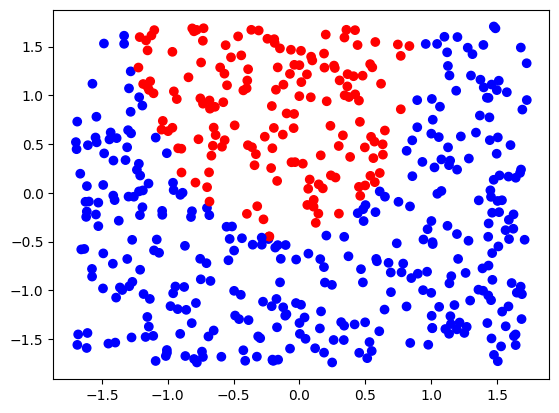

In [187]:
report = classification_report(y_test, y_pred)
print(report)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
visualize_data(X_test_np, y_pred)

## Dataset three (DF3.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [188]:
df3 = DFs[2]

# Define features and target
X = df3[['x1', 'x2']]
y = df3['y']

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_np = np.array(X_train_scaled)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test_scaled)
y_test_np = np.array(y_test)


# Display the shapes of the resulting sets
print(X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)

(1167, 2) (292, 2) (1167,) (292,)


Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [189]:
def polynomial_kernel(X, Y, degree=2, coef0=1):
    K = (np.dot(X, Y.T) + coef0) ** degree
    return K

def svm_solver(X_train, y_train, degree=2, coef0=1):
    n_samples = X_train.shape[0]
    K = polynomial_kernel(X_train, X_train, degree, coef0) + np.eye(n_samples) * 1e-6  # Kernel matrix with adjustment

    alpha = cp.Variable(n_samples)
    P = np.multiply(np.outer(y_train, y_train), K)  # Element-wise multiplication for P matrix

    # Ensure matrix P is treated as PSD without certification step
    P = cp.psd_wrap(P)

    objective = cp.Maximize(1/2 * cp.quad_form(alpha, -P) + cp.sum(alpha))
    constraints = [alpha >= 0, alpha <= 1, cp.sum(alpha * y_train) == 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    alpha_value = alpha.value
    sv_indices = alpha_value > 1e-5
    sv = X_train[sv_indices]
    sv_labels = y_train[sv_indices]
    bias = compute_bias(alpha_value, y_train, K, sv_indices)

    return alpha_value, sv_indices, sv, sv_labels, bias

def compute_bias(alpha, y_train, K, support_vector_indices):
    return np.mean(y_train[support_vector_indices] - np.dot(K[support_vector_indices], alpha * y_train))

# Assuming X_train_np, y_train_np, X_test_scaled are defined
alpha_value, sv_indices, support_vectors, support_vector_labels, bias = svm_solver(X_train_np, y_train_np)

print("Optimal alpha values:", alpha_value)
print("Support vectors:", support_vectors)
print("Bias term:", bias)


/opt/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 30 times so far.

  warnings.warn(msg, UserWarning)


Optimal alpha values: [ 4.89707005e-07 -1.54122370e-07  5.50045250e-06 ...  4.58456009e-08
 -1.25488334e-06  9.99996539e-01]
Support vectors: [[-0.82165019  0.99410032]
 [-1.32387735  0.4128639 ]
 [-0.54269111 -1.2063896 ]
 [ 1.43231169  0.10969667]
 [-0.96679286 -0.99056541]
 [-1.1808183   0.80748813]
 [ 1.4397369   0.18866194]
 [-1.33540195  0.50722976]
 [-1.34787368 -0.17904176]
 [ 1.02611217  0.9870392 ]
 [-0.09091092 -1.49291021]
 [-0.51765955  1.3840472 ]
 [-0.07580756 -1.40340855]
 [ 1.25099302  0.01903671]
 [ 1.2221013   0.46021881]
 [ 0.56085607 -1.143814  ]
 [ 0.43306157  1.23067103]
 [ 0.40408839 -1.35141341]
 [-0.52092881  1.36271141]
 [-1.40011415 -0.42420496]
 [-1.25989808 -0.38863763]
 [-1.45219954 -0.10260251]
 [-1.45420213 -0.37338909]
 [-0.86693819  0.95785411]
 [-1.0046317   0.85326281]
 [ 1.34598224  0.50555102]
 [-0.98048912 -0.96679892]
 [ 1.41755182 -0.11319842]
 [ 0.91854769  0.87192038]
 [-1.20279806 -0.50256815]
 [ 0.57199986  1.14007402]
 [-0.44237829  1.2325

Predict the class of each entry in the test set using your learned model.

In [190]:
def predict(X, support_vectors, support_vector_indices, alpha, y_train, bias, degree=2, coef0=1):
    """
    Predict the class labels for the input samples X using the learned SVM model with Polynomial kernel.
    
    Args:
    - X (numpy array): Test samples to predict.
    - support_vectors (numpy array): Support vectors from the training set.
    - support_vector_indices (numpy array): Indices of the support vectors.
    - alpha (numpy array): Optimal alpha values from the SVM solver.
    - y_train (numpy array): Training labels.
    - bias (float): Bias term from the SVM solver.
    - degree (int): Degree of the polynomial kernel.
    - coef0 (float): Independent term in the polynomial kernel.

    Returns:
    - y_pred (numpy array): Predicted class labels for the input samples X.
    """
    # Only use the support vectors' alphas and labels
    support_alphas = alpha[support_vector_indices]
    support_y_train = y_train[support_vector_indices]

    # Compute the kernel between the test samples and support vectors
    K_test = polynomial_kernel(X, support_vectors, degree, coef0)
    
    # Compute the decision function
    decision_function = np.dot(K_test, support_alphas * support_y_train) + bias
    
    # Predict the class labels based on the sign of the decision function
    y_pred = np.sign(decision_function)
    
    return y_pred

# Assuming X_test_scaled is defined
y_pred = predict(X_test_scaled, support_vectors, sv_indices, alpha_value, y_train_np, bias)

print("Predicted class labels:", y_pred)


Predicted class labels: [ 1.  1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1.  1.
  1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.
 -1. -1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1. -1. -1.
  1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1.
 -1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.
 -1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1. -1.
  1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.
  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.
 -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1. -1.  1.
  1. -1.  1.  1.  1.  1.  1

Use classification_report function (from sklearn) to get the accuracy of your model.

              precision    recall  f1-score   support

          -1       1.00      0.99      1.00       152
           1       0.99      1.00      1.00       140

    accuracy                           1.00       292
   macro avg       1.00      1.00      1.00       292
weighted avg       1.00      1.00      1.00       292

Accuracy: 0.9965753424657534


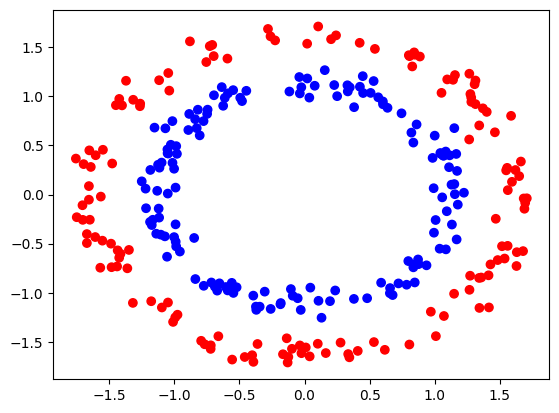

In [191]:
report = classification_report(y_test, y_pred)
print(report)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
visualize_data(X_test_np, y_pred)